In [27]:
import os
from tensorflow import keras

from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers

In [ ]:
!ls -lh


total 8.7M
drwxr-xr-x 3 root root 4.0K Dec  8 02:44 captcha_images_v2
-rw-r--r-- 1 root root 8.7M Dec  8 02:44 captcha_images_v2.zip
drwxr-xr-x 1 root root 4.0K Dec  5 14:24 sample_data


In [28]:
!unzip -q captcha_images_v2.zip -d captcha_images_v2/


replace captcha_images_v2/captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
data_dir = Path("./captcha_images_v2/captcha_images_v2/")
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = sorted(set(char for label in labels for char in label))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16
img_width, img_height = 200, 50
downsample_factor = 4
max_length = max([len(label) for label in labels])


Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [32]:
# Correct initialization
# Correct initialization
char_to_num = layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



def split_data(images, labels, train_size=0.9, shuffle=True):
    if not (0 <= train_size <= 1):
        raise ValueError("train_size must be between 0 and 1.")
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

# create dataset objects

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


# visualization

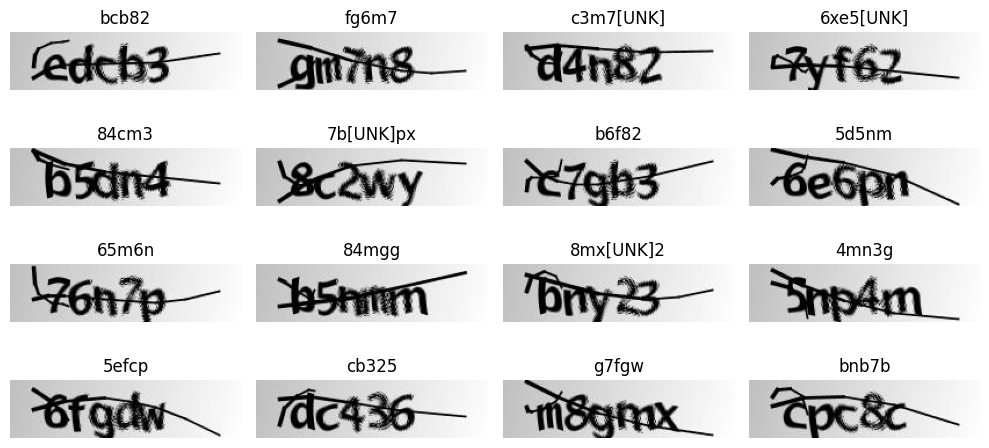

In [34]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
ax = ax.flatten()  # Flatten the axes array for easier indexing

for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i].imshow(img[:, :, 0].T, cmap="gray")  # Transpose for correct orientation
        ax[i].set_title(label)
        ax[i].axis("off")

plt.tight_layout()
plt.show()

In [39]:
class CTCLayer(layers.Layer):
  def __init__(self,name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self,y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0],dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1],dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1],dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len,1),dtype = "int64")
    label_length = label_length * tf.ones(shape=(batch_len,1),dtype='int64')

    loss = self.loss_fn(y_true,y_pred,input_length,label_length)
    self.add_loss(loss)

    return y_pred

def build_model():
  input_img = layers.Input(shape=(img_width,img_height,1),name='image',dtype='float32')
  labels = layers.Input(name='label',shape=(None,),dtype="float32")

  x = layers.Conv2D(
      32,
      (3,3),
      activation='relu',
      kernel_initializer='he_normal',
      padding="same",
      name='Conv1',
  )(input_img)
  x = layers.MaxPooling2D((2,2),name='pool1')(x)

  x = layers.Conv2D(
      64,
      (3,3),
      activation='relu',
      kernel_initializer='he_normal',
      padding="same",
      name="Conv2",
  )(x)

  x = layers.MaxPooling2D((2,2), name='pool2')(x)

  new_shape = ((img_width //4),(img_height //4) *64)
  x = layers.Reshape(target_shape=new_shape,name='reshape')(x)
  x = layers.Dense(64, activation='relu',name = 'dense1')(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Bidirectional(layers.LSTM(128, return_sequences= True, dropout=0.25))(x)
  x = layers.Bidirectional(layers.LSTM(64,return_sequences = True,dropout=0.25))(x)

  x = layers.Dense(len(characters)+1,activation='softmax',name='dense2')(x)

  output = CTCLayer(name='ctc_loss')(labels,x)

  model = keras.models.Model(
      inputs=[input_img,labels],outputs=output,name='ocr_model_v1'
  )

  opt = keras.optimizers.Adam()
  model.compile(optimizer=opt)
  return model

model = build_model()
model.summary()


Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_12          │ (None, 50, 256)        │        197,632 │ dropout_6[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_13          │ (None, 50, 128)        │        164,352 │ bidirectional_12[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 20)         │          2,580 │ bidirectional_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 20)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Neural Network

In [40]:
epochs = 100
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=early_stopping_patience,restore_best_weights=True
)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 435ms/step - loss: 535.2698 - val_loss: 252.1781
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - loss: 262.0537 - val_loss: 251.6748
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 43s 417ms/step - loss: 261.5578 - val_loss: 251.8015
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - loss: 261.6920 - val_loss: 251.8035
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 434ms/step - loss: 261.6536 - val_loss: 251.8736
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - loss: 261.6270 - val_loss: 251.7437
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 379ms/step - loss: 261.4283 - val_loss: 251.7693
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 409ms/step - loss: 261.3488 - val_loss: 251.9433
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 25s 419ms/step - loss: 261.2004 - val_loss: 251.9474
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step - loss: 261.0900 - val_loss: 251.8037
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - loss: 260.9960 - val_l

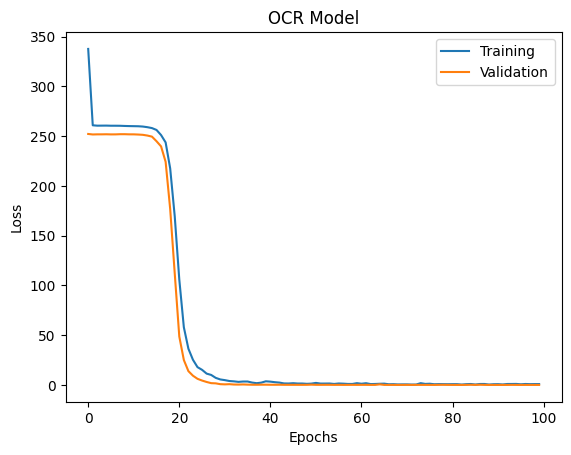

In [41]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.title("OCR Model")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training','Validation'],loc='upper right')
plt.show()